In [58]:
import pandas as pd

def clean(week_nums):
    dfs = []
    for week_num in week_nums:
        url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
        file_url = url.format(week_num)
        names = ['c_a', 'unit', 'scp', 'station', 'linename', 'division', 
                 'date', 'time', 'desc', 'entries', 'exits']
        df = pd.read_csv(file_url, names=names, parse_dates=[['date','time']], 
                         keep_date_col=True, skiprows=1)
        df['date'] = pd.to_datetime(df['date'])
        df['day_of_week'] = df['date_time'].dt.day_name()
        df = df[(~df['c_a'].str.contains('PTH') & 
                 ~df['desc'].str.contains('RECOVR') & 
                 df.time.astype(str).str.contains('00:00'))]
        df = df[['station', 'unit', 'c_a', 'scp', 'date_time', 'date', 'day_of_week', 'time', 
                'desc', 'entries', 'exits']]
        #delete duplicates -> could be done after dataframe creation instead of in this loop
        df.sort_values(['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True, ascending=False)
        df.drop_duplicates(subset=['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True)
        dfs.append(df)
        print(week_num)
    return pd.concat(dfs)

week_nums = [200613, 200620, 200627]

In [59]:
turnstiles_df = clean(week_nums)

200613
200620
200627


In [60]:
turnstiles_df.date


206661   2020-06-12
206660   2020-06-12
206659   2020-06-12
206658   2020-06-12
206657   2020-06-12
            ...    
4        2020-06-20
3        2020-06-20
2        2020-06-20
1        2020-06-20
0        2020-06-20
Name: date, Length: 568174, dtype: datetime64[ns]

In [61]:
turnstiles_block = (turnstiles_df
                        .groupby(["c_a", "unit", "scp", "station", "date_time", "exits"],as_index=False).entries.first())
turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block
                                                       .groupby(["c_a", "unit", "scp", "station"])["date_time", "entries", "exits"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_block.dropna(subset=["prev_datetime"], axis=0, inplace=True)
def get_counts_entry(row, max_counter):
    counter = row["entries"] - row["prev_entries"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["entries"], row["prev_entries"])
        counter = min(row["entries"], row["prev_entries"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter
def get_counts_exit(row, max_counter):
    counter = row["exits"] - row["prev_exits"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["exits"], row["prev_exits"])
        counter = min(row["exits"], row["prev_exits"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

<ipython-input-61-7112b57ef14a>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block


In [62]:
turnstiles_block['delta_entries'] = turnstiles_block.apply(get_counts_entry, axis=1, max_counter=1e5)

3 563309.0
43 8360152.0
14 572793.0
9 621129.0
14 1200424.0
1001657 12763558.0
12763562 1001657.0
12 2393140.0
2555909 514070.0
37 6871938.0
56 499510.0
5 235111205.0
40 297261.0
78 920207.0
262144 0.0
654322392 2808057.0
2808205 654322392.0
327721 17080.0
6 6362738.0
66 371906.0
14 795788.0
15 6666024.0
1703967 17387249.0
31 517645.0
20 4362577.0


In [117]:
turnstiles_block['delta_exits'] = turnstiles_block.apply(get_counts_exit, axis=1, max_counter=15000)
turnstiles_block

2 435092.0
22 10927677.0
4 23650.0
2 560805.0
28 2390294.0
45672 2811504.0
2811559 45672.0
1 1578147.0
65536 24623.0
22 2544858.0
111 487353.0
2 369423816.0
112 68396.0
65537 83.0
11 107524.0
67101704 1833174.0
1833360 67101704.0
22 22673.0
1 4801301.0
14 704722.0
4 206758.0
2 850518.0
5 3597248.0
12 285863.0
3 12265276.0


,c_a,unit,scp,station,date_time,exits,entries,prev_datetime,prev_entries,prev_exits,delta_entries,delta_exits
1,A002,R051,02-00-00,59 ST,2020-06-06 04:00:00,2521130,7420920,2020-06-06 00:00:00,7420920.0,2521129.0,0.0,1.0
2,A002,R051,02-00-00,59 ST,2020-06-06 08:00:00,2521141,7420928,2020-06-06 04:00:00,7420920.0,2521130.0,8.0,11.0
3,A002,R051,02-00-00,59 ST,2020-06-06 12:00:00,2521163,7420941,2020-06-06 08:00:00,7420928.0,2521141.0,13.0,22.0
4,A002,R051,02-00-00,59 ST,2020-06-06 16:00:00,2521174,7420972,2020-06-06 12:00:00,7420941.0,2521163.0,31.0,11.0
5,A002,R051,02-00-00,59 ST,2020-06-06 20:00:00,2521184,7421007,2020-06-06 16:00:00,7420972.0,2521174.0,35.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
568169,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 05:00:00,514,5554,2020-06-26 01:00:00,5554.0,514.0,0.0,0.0
568170,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 09:00:00,514,5554,2020-06-26 05:00:00,5554.0,514.0,0.0,0.0
568171,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 13:00:00,514,5554,2020-06-26 09:00:00,5554.0,514.0,0.0,0.0
568172,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 17:00:00,514,5554,2020-06-26 13:00:00,5554.0,514.0,0.0,0.0


In [118]:
# mf = turnstiles_block.groupby(['unit', 'station', 'date_time',]).agg({'delta_exits': 'sum'}).reset_index()
# mf[:50]

In [119]:



# top10 = (mf.sort_values(by='delta_exits',ascending=False).station.head(10))
# #pd.DataFrame(top10)
# top10

In [120]:
#unit vs Station name
#station complexes vs units vs sationts?

unit_hourly = (turnstiles_block.groupby(['unit','station','date_time'])['delta_exits'].sum().reset_index())

In [121]:
unit_hourly[:50]

,unit,station,date_time,delta_exits
0,R001,SOUTH FERRY,2020-06-06 05:00:00,35.0
1,R001,SOUTH FERRY,2020-06-06 09:00:00,136.0
2,R001,SOUTH FERRY,2020-06-06 13:00:00,187.0
3,R001,SOUTH FERRY,2020-06-06 17:00:00,240.0
4,R001,SOUTH FERRY,2020-06-06 21:00:00,191.0
5,R001,SOUTH FERRY,2020-06-07 01:00:00,130.0
6,R001,SOUTH FERRY,2020-06-07 05:00:00,52.0
7,R001,SOUTH FERRY,2020-06-07 09:00:00,104.0
8,R001,SOUTH FERRY,2020-06-07 13:00:00,159.0
9,R001,SOUTH FERRY,2020-06-07 17:00:00,237.0


In [122]:
top = unit_hourly.groupby(['unit', 'date_time'])['delta_exits'].sum().reset_index()

        

top10 = (top.sort_values(by=['delta_exits'],ascending=False)
        .unit.head(100))

In [123]:
top10units = top10.unique()[:10]
top10units

array(['R170', 'R102', 'R055', 'R018', 'R011', 'R020', 'R097', 'R025',
       'R024', 'R022'], dtype=object)

In [124]:
top5units = top10.unique()[:5]
top5units

array(['R170', 'R102', 'R055', 'R018', 'R011'], dtype=object)

In [125]:
top10.head(100)

19924    R170
11489    R102
19930    R170
19916    R170
19928    R170
         ... 
2293     R020
19845    R170
2931     R025
2003     R018
6480     R055
Name: unit, Length: 100, dtype: object

In [126]:
top.iloc[2133]

unit                          R019
date_time      2020-06-11 16:00:00
delta_exits                    534
Name: 2133, dtype: object

In [127]:
mask = (unit_hourly['unit'] == 'R001')
sample_df = unit_hourly[mask].head(50)

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Text(98.5, 0.5, 'Traffic')

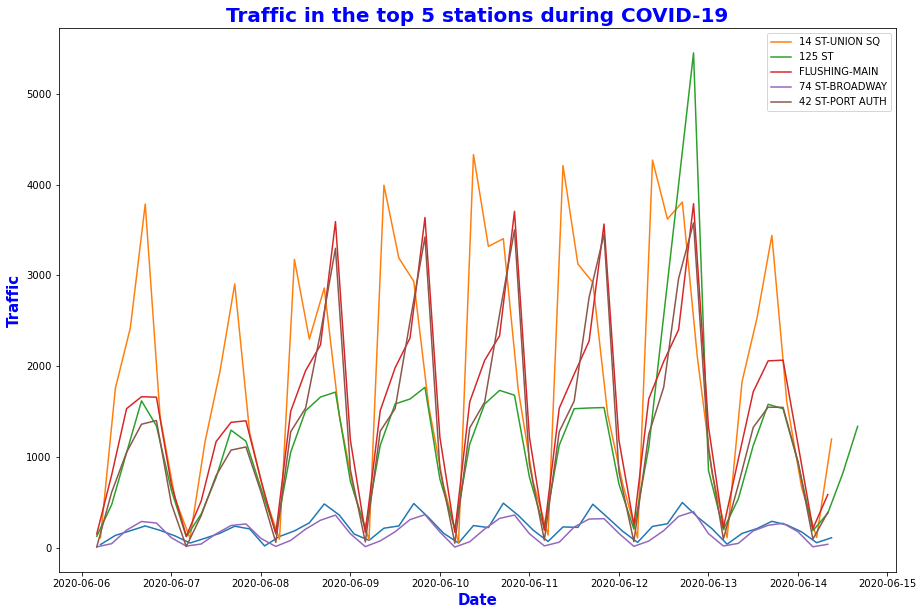

In [141]:
plt.figure(figsize=[15,10])
plt.plot(sample_df.date_time, sample_df.delta_exits)

for i in top5units:
    mask = (unit_hourly['unit'] == i)
    top5_df = unit_hourly[mask].head(50)

    plt.plot(top5_df.date_time, top5_df.delta_exits, label = top5_df.station.iloc[0])
plt.legend()

plt.savefig('top5 stations traffic.png')

plt.title('Traffic in the top 5 stations during COVID-19', fontsize=20, weight='bold',color='b')
plt.xlabel('Date', fontsize=15, weight='bold',color='b')
plt.ylabel('Traffic', fontsize=15, weight='bold',color='b')

In [130]:
plt.figure(figsize=[15,10])
plt.plot(sample_df.date_time, sample_df.delta_exits)

for i in top10units:
    mask = (unit_hourly['unit'] == i)
    top5_df = unit_hourly[mask].head(50)

    plt.plot(top5_df.date_time, top5_df.delta_exits, label = unit_hourly['unit' ==i]
plt.legend()

SyntaxError: invalid syntax (<ipython-input-130-afb0777968e8>, line 9)